## 平时作业（1）：多层神经网络的训练

- 李锦韬 2201213292

### 作业要求

**请根据自己的计算环境情况和兴趣，选择以下两个数据集之一，完成如下的实验：**    
- http://yann.lecun.com/exdb/mnist/
- https://www.cs.toronto.edu/~kriz/cifar.html

**1. 构造一个多层的神经网络（注意，不要使用卷积神经网络，本题目要求使用多层神经网络），并在上述数据集任务上进行训练，并汇报一个“使用了你认为最优的超参数配置的神经网络”的学习曲线；要求如下：**
* （1）自己手动完成反向传播算法部分的编写；
* （2）该网络应为一个“纯净”的多层神经网络，不使用正则化方法、率优化算法等；

**2. 在上述“你认为最优配置的神经网络”的基础上，**
* （1）分别汇报“增加一个隐藏层”和“减小一个隐藏层”情况下的学习曲线； 
* （2）分别汇报使用BGD和SGD进行训练的学习曲线；
* （3）分别汇报使用两种以上参数初始化方法下的学习曲线；
* （4）分别汇报使用两种以上学习率优化算法下的学习曲线；
* （5）分别汇报使用两种以上正则化方法下的学习曲线；

**最终提交：包含6个子文件夹的一个zip文件，其中的子文件夹应包含：**
* （1）对应上述6种情况之一的一份源代码；
* （2）对应上述源代码的学习曲线的一个.png文件；

## 6. 使用不同正则化方法

### 6.0 不使用正则化

Epoch 1/30, train loss: 0.097082, train acc: 0.962367, test acc: 0.961200
Epoch 2/30, train loss: 0.167050, train acc: 0.973250, test acc: 0.968600
Epoch 3/30, train loss: 0.060306, train acc: 0.979100, test acc: 0.972900
Epoch 4/30, train loss: 0.125626, train acc: 0.982017, test acc: 0.972200
Epoch 5/30, train loss: 0.021182, train acc: 0.984950, test acc: 0.974100
Epoch 6/30, train loss: 0.013545, train acc: 0.986950, test acc: 0.976000
Epoch 7/30, train loss: 0.067803, train acc: 0.989017, test acc: 0.975600
Epoch 8/30, train loss: 0.025629, train acc: 0.989667, test acc: 0.976100
Epoch 9/30, train loss: 0.026081, train acc: 0.991450, test acc: 0.977100
Epoch 10/30, train loss: 0.026623, train acc: 0.992983, test acc: 0.977700
Epoch 11/30, train loss: 0.043815, train acc: 0.993900, test acc: 0.978500
Epoch 12/30, train loss: 0.036088, train acc: 0.994433, test acc: 0.979100
Epoch 13/30, train loss: 0.015385, train acc: 0.995383, test acc: 0.978000
Epoch 14/30, train loss: 0.043922,

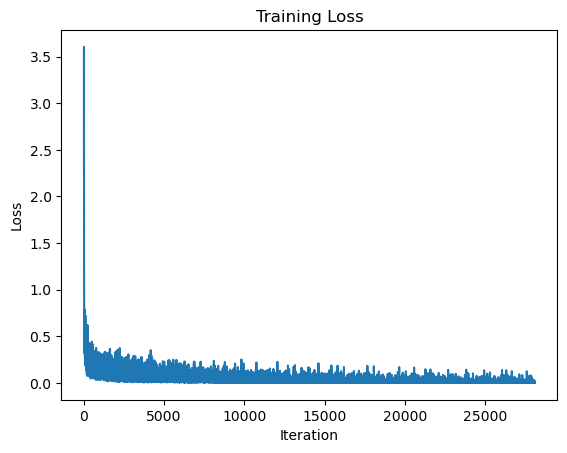

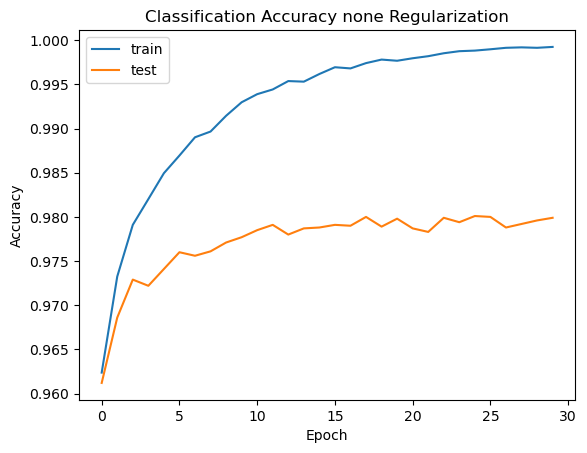

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 获取MNIST数据集
def load_mnist():
    with open("../data/" + "mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]
X_train, y_train, X_test, y_test = load_mnist()

# 归一化处理
X_train = X_train / 255.0
X_test = X_test / 255.0

# 标准化处理
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

# 将标签转化为one-hot向量
n_classes = 10
y_train = np.eye(n_classes)[y_train]
y_test = np.eye(n_classes)[y_test]

# 定义网络结构
input_size = X_train.shape[1]
hidden_size_1 = 128
hidden_size_2 = 64
output_size = n_classes

# 初始化权重和偏置 采用随机初始化
W1 = np.random.randn(input_size, hidden_size_1) / np.sqrt(input_size)
b1 = np.zeros(hidden_size_1)
W2 = np.random.randn(hidden_size_1, hidden_size_2) / np.sqrt(hidden_size_1)
b2 = np.zeros(hidden_size_2)
W3 = np.random.randn(hidden_size_2, output_size) / np.sqrt(hidden_size_2)
b3 = np.zeros(output_size)

# 使用AdaGrad算法更新权重和偏置
sw1 = np.zeros_like(W1)
sb1 = np.zeros_like(b1)
sw2 = np.zeros_like(W2)
sb2 = np.zeros_like(b2)
sw3 = np.zeros_like(W3)
sb3 = np.zeros_like(b3)

# 定义激活函数和损失函数
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exps / np.sum(exps, axis=-1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    n_samples = y_pred.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + 1e-12)) / n_samples
    return loss

# 定义训练函数
def train(X, y_true, learning_rate, reg_lambda):
    global W1, W2, W3, b1, b2, b3
    # 前向传播
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    y_pred = softmax(z3)
    m = y_true.shape[0]
    # 计算损失函数值和梯度
    loss = cross_entropy_loss(y_pred, y_true)

    grad_y_pred = y_pred - y_true

    grad_W3 = 1./m*np.dot(a2.T, grad_y_pred) + 1./m * reg_lambda * np.sign(W3)
    grad_b3 = 1./m*np.sum(grad_y_pred, axis=0)
    grad_a2 = np.dot(grad_y_pred, W3.T)

    grad_z2 = grad_a2.copy()
    grad_z2[z2 < 0] = 0
    grad_W2 = 1./m*np.dot(a1.T, grad_z2) + 1./m * reg_lambda * np.sign(W2)
    grad_b2 = 1./m*np.sum(grad_z2, axis=0)
    grad_a1 = np.dot(grad_z2, W2.T)

    grad_z1 = grad_a1.copy()
    grad_z1[z1 < 0] = 0
    grad_W1 = 1./m*np.dot(X.T, grad_z1) + 1./m * reg_lambda * np.sign(W1)
    grad_b1 = 1./m*np.sum(grad_z1, axis=0)

    # 使用AdaGrad算法更新权重和偏置
    global sw1, sb1, sw2, sb2, sw3, sb3
    sw3 = sw3 + grad_W3**2
    sb3 = sb3 + grad_b3**2
    W3 -= learning_rate * grad_W3 / (np.sqrt(sw3) + 1e-7)
    b3 -= learning_rate * grad_b3 / (np.sqrt(sb3) + 1e-7)

    sw2 = sw2 + grad_W2**2
    sb2 = sb2 + grad_b2**2
    W2 -= learning_rate * grad_W2 / (np.sqrt(sw2) + 1e-7)
    b2 -= learning_rate * grad_b2 / (np.sqrt(sb2) + 1e-7)

    sw1 = sw1 + grad_W1**2
    sb1 = sb1 + grad_b1**2
    W1 -= learning_rate * grad_W1 / (np.sqrt(sw1) + 1e-7)
    b1 -= learning_rate * grad_b1 / (np.sqrt(sb1) + 1e-7)

    return loss

def predict(X):
    global W1, W2, W3, b1, b2, b3
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    y_pred = softmax(z3)
    return np.argmax(y_pred, axis=-1)

learning_rate = 0.01
reg_lambda = 0
num_epochs = 30
batch_size = 64
num_batches = X_train.shape[0] // batch_size

train_loss_history = []
train_acc_history0 = []
test_acc_history0 = []
for epoch in range(num_epochs):
    # 在每个epoch前随机打乱训练数据
    permutation = np.random.permutation(X_train.shape[0])
    X_train = X_train[permutation]
    y_train = y_train[permutation]
    for i in range(num_batches):
        # 从训练数据中随机抽取一个batch
        X_batch = X_train[i * batch_size:(i + 1) * batch_size]
        y_batch = y_train[i * batch_size:(i + 1) * batch_size]

        # 训练一个batch，并记录损失函数值
        loss = train(X_batch, y_batch, learning_rate, reg_lambda)
        train_loss_history.append(loss)

    # 计算训练集和测试集上的精度
    train_acc = np.mean(predict(X_train) == np.argmax(y_train, axis=-1))
    test_acc = np.mean(predict(X_test) == np.argmax(y_test, axis=-1))
    train_acc_history0.append(train_acc)
    test_acc_history0.append(test_acc)

    # 输出训练进度
    print('Epoch %d/%d, train loss: %f, train acc: %f, test acc: %f' % (epoch+1, num_epochs, loss, train_acc, test_acc))

plt.plot(train_loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

plt.plot(train_acc_history0, label='train')
plt.plot(test_acc_history0, label='test')
plt.title('Classification Accuracy none Regularization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 6.1 使用L1正则化

Epoch 1/30, train loss: 0.226023, train acc: 0.909583, test acc: 0.914700
Epoch 2/30, train loss: 0.366449, train acc: 0.924150, test acc: 0.926100
Epoch 3/30, train loss: 0.277238, train acc: 0.926667, test acc: 0.926600
Epoch 4/30, train loss: 0.409260, train acc: 0.929683, test acc: 0.931700
Epoch 5/30, train loss: 0.258445, train acc: 0.932833, test acc: 0.933400
Epoch 6/30, train loss: 0.211571, train acc: 0.932533, test acc: 0.933300
Epoch 7/30, train loss: 0.554775, train acc: 0.934117, test acc: 0.935400
Epoch 8/30, train loss: 0.301868, train acc: 0.935350, test acc: 0.936700
Epoch 9/30, train loss: 0.264958, train acc: 0.935583, test acc: 0.937100
Epoch 10/30, train loss: 0.146012, train acc: 0.937517, test acc: 0.937600
Epoch 11/30, train loss: 0.170781, train acc: 0.937817, test acc: 0.937000
Epoch 12/30, train loss: 0.367688, train acc: 0.938450, test acc: 0.938900
Epoch 13/30, train loss: 0.235918, train acc: 0.939600, test acc: 0.939500
Epoch 14/30, train loss: 0.224833,

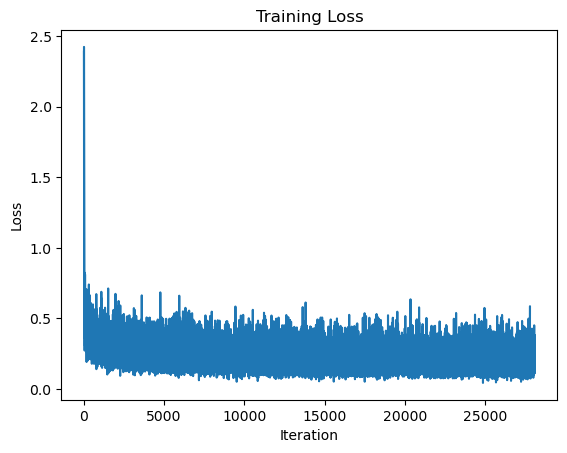

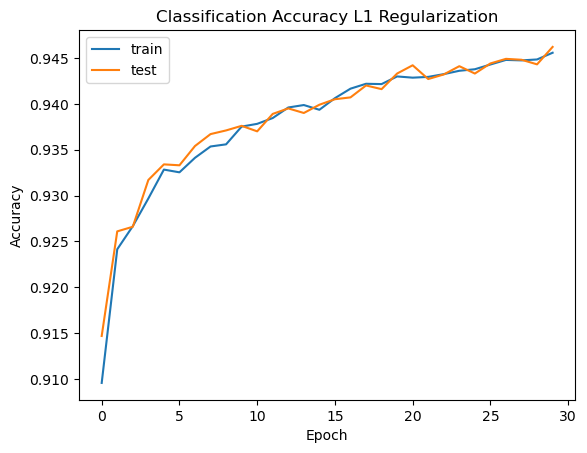

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 获取MNIST数据集
def load_mnist():
    with open("../data/" + "mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]
X_train, y_train, X_test, y_test = load_mnist()

# 归一化处理
X_train = X_train / 255.0
X_test = X_test / 255.0

# 标准化处理
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

# 将标签转化为one-hot向量
n_classes = 10
y_train = np.eye(n_classes)[y_train]
y_test = np.eye(n_classes)[y_test]

# 定义网络结构
input_size = X_train.shape[1]
hidden_size_1 = 128
hidden_size_2 = 64
output_size = n_classes

# 初始化权重和偏置 采用随机初始化
W1 = np.random.randn(input_size, hidden_size_1) / np.sqrt(input_size)
b1 = np.zeros(hidden_size_1)
W2 = np.random.randn(hidden_size_1, hidden_size_2) / np.sqrt(hidden_size_1)
b2 = np.zeros(hidden_size_2)
W3 = np.random.randn(hidden_size_2, output_size) / np.sqrt(hidden_size_2)
b3 = np.zeros(output_size)

# 使用AdaGrad算法更新权重和偏置
sw1 = np.zeros_like(W1)
sb1 = np.zeros_like(b1)
sw2 = np.zeros_like(W2)
sb2 = np.zeros_like(b2)
sw3 = np.zeros_like(W3)
sb3 = np.zeros_like(b3)

# 定义激活函数和损失函数
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exps / np.sum(exps, axis=-1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    n_samples = y_pred.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + 1e-12)) / n_samples
    return loss

# 定义训练函数
def train(X, y_true, learning_rate, reg_lambda):
    global W1, W2, W3, b1, b2, b3
    # 前向传播
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    y_pred = softmax(z3)
    m = y_true.shape[0]
    # 计算损失函数值和梯度
    loss = cross_entropy_loss(y_pred, y_true)

    grad_y_pred = y_pred - y_true

    grad_W3 = 1./m*np.dot(a2.T, grad_y_pred) + 1./m * reg_lambda * np.sign(W3)
    grad_b3 = 1./m*np.sum(grad_y_pred, axis=0)
    grad_a2 = np.dot(grad_y_pred, W3.T)

    grad_z2 = grad_a2.copy()
    grad_z2[z2 < 0] = 0
    grad_W2 = 1./m*np.dot(a1.T, grad_z2) + 1./m * reg_lambda * np.sign(W2)
    grad_b2 = 1./m*np.sum(grad_z2, axis=0)
    grad_a1 = np.dot(grad_z2, W2.T)

    grad_z1 = grad_a1.copy()
    grad_z1[z1 < 0] = 0
    grad_W1 = 1./m*np.dot(X.T, grad_z1) + 1./m * reg_lambda * np.sign(W1)
    grad_b1 = 1./m*np.sum(grad_z1, axis=0)

    # 使用AdaGrad算法更新权重和偏置
    global sw1, sb1, sw2, sb2, sw3, sb3
    sw3 = sw3 + grad_W3**2
    sb3 = sb3 + grad_b3**2
    W3 -= learning_rate * grad_W3 / (np.sqrt(sw3) + 1e-7)
    b3 -= learning_rate * grad_b3 / (np.sqrt(sb3) + 1e-7)

    sw2 = sw2 + grad_W2**2
    sb2 = sb2 + grad_b2**2
    W2 -= learning_rate * grad_W2 / (np.sqrt(sw2) + 1e-7)
    b2 -= learning_rate * grad_b2 / (np.sqrt(sb2) + 1e-7)

    sw1 = sw1 + grad_W1**2
    sb1 = sb1 + grad_b1**2
    W1 -= learning_rate * grad_W1 / (np.sqrt(sw1) + 1e-7)
    b1 -= learning_rate * grad_b1 / (np.sqrt(sb1) + 1e-7)

    return loss

def predict(X):
    global W1, W2, W3, b1, b2, b3
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    y_pred = softmax(z3)
    return np.argmax(y_pred, axis=-1)

learning_rate = 0.01
reg_lambda = 0.1
num_epochs = 30
batch_size = 64
num_batches = X_train.shape[0] // batch_size

train_loss_history = []
train_acc_history = []
test_acc_history = []
for epoch in range(num_epochs):
    # 在每个epoch前随机打乱训练数据
    permutation = np.random.permutation(X_train.shape[0])
    X_train = X_train[permutation]
    y_train = y_train[permutation]
    for i in range(num_batches):
        # 从训练数据中随机抽取一个batch
        X_batch = X_train[i * batch_size:(i + 1) * batch_size]
        y_batch = y_train[i * batch_size:(i + 1) * batch_size]

        # 训练一个batch，并记录损失函数值
        loss = train(X_batch, y_batch, learning_rate, reg_lambda)
        train_loss_history.append(loss)

    # 计算训练集和测试集上的精度
    train_acc = np.mean(predict(X_train) == np.argmax(y_train, axis=-1))
    test_acc = np.mean(predict(X_test) == np.argmax(y_test, axis=-1))
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)

    # 输出训练进度
    print('Epoch %d/%d, train loss: %f, train acc: %f, test acc: %f' % (epoch+1, num_epochs, loss, train_acc, test_acc))

plt.plot(train_loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

plt.plot(train_acc_history, label='train')
plt.plot(test_acc_history, label='test')
plt.title('Classification Accuracy L1 Regularization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 6.2 使用L2正则化

Epoch 1/30, train loss: 0.141098, train acc: 0.961150, test acc: 0.959100
Epoch 2/30, train loss: 0.066068, train acc: 0.972800, test acc: 0.968300
Epoch 3/30, train loss: 0.166661, train acc: 0.975983, test acc: 0.969400
Epoch 4/30, train loss: 0.055986, train acc: 0.980050, test acc: 0.971800
Epoch 5/30, train loss: 0.064860, train acc: 0.982067, test acc: 0.975300
Epoch 6/30, train loss: 0.062467, train acc: 0.983617, test acc: 0.975900
Epoch 7/30, train loss: 0.055333, train acc: 0.984233, test acc: 0.974000
Epoch 8/30, train loss: 0.045101, train acc: 0.986183, test acc: 0.976400
Epoch 9/30, train loss: 0.098654, train acc: 0.986600, test acc: 0.977500
Epoch 10/30, train loss: 0.023169, train acc: 0.987467, test acc: 0.977000
Epoch 11/30, train loss: 0.067944, train acc: 0.987233, test acc: 0.978100
Epoch 12/30, train loss: 0.051323, train acc: 0.987983, test acc: 0.976800
Epoch 13/30, train loss: 0.069714, train acc: 0.988983, test acc: 0.978900
Epoch 14/30, train loss: 0.044380,

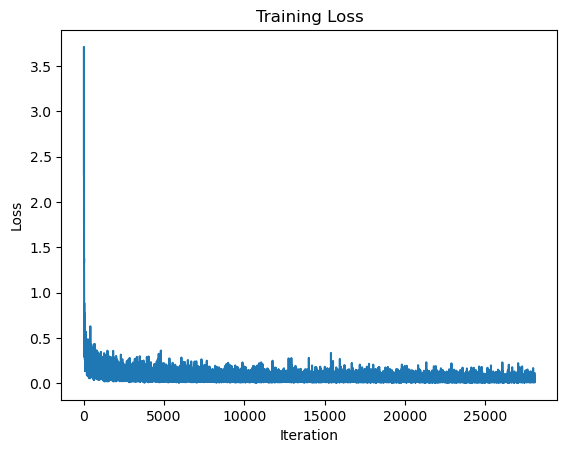

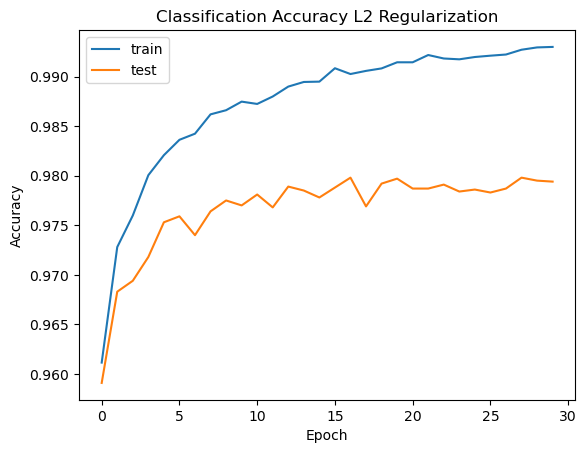

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 获取MNIST数据集
def load_mnist():
    with open("../data/" + "mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]
X_train, y_train, X_test, y_test = load_mnist()

# 归一化处理
X_train = X_train / 255.0
X_test = X_test / 255.0

# 标准化处理
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

# 将标签转化为one-hot向量
n_classes = 10
y_train = np.eye(n_classes)[y_train]
y_test = np.eye(n_classes)[y_test]

# 定义网络结构
input_size = X_train.shape[1]
hidden_size_1 = 128
hidden_size_2 = 64
output_size = n_classes

# 初始化权重和偏置 采用随机初始化
W1 = np.random.randn(input_size, hidden_size_1) / np.sqrt(input_size)
b1 = np.zeros(hidden_size_1)
W2 = np.random.randn(hidden_size_1, hidden_size_2) / np.sqrt(hidden_size_1)
b2 = np.zeros(hidden_size_2)
W3 = np.random.randn(hidden_size_2, output_size) / np.sqrt(hidden_size_2)
b3 = np.zeros(output_size)

# 使用AdaGrad算法更新权重和偏置
sw1 = np.zeros_like(W1)
sb1 = np.zeros_like(b1)
sw2 = np.zeros_like(W2)
sb2 = np.zeros_like(b2)
sw3 = np.zeros_like(W3)
sb3 = np.zeros_like(b3)

# 定义激活函数和损失函数
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exps / np.sum(exps, axis=-1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    n_samples = y_pred.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + 1e-12)) / n_samples
    return loss

# 定义训练函数
def train(X, y_true, learning_rate, reg_lambda):
    global W1, W2, W3, b1, b2, b3
    # 前向传播
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    y_pred = softmax(z3)
    m = y_true.shape[0]
    # 计算损失函数值和梯度
    loss = cross_entropy_loss(y_pred, y_true)

    grad_y_pred = y_pred - y_true

    # L2正则化
    grad_W3 = 1./m*np.dot(a2.T, grad_y_pred) + 2./m * reg_lambda * W3
    grad_b3 = 1./m*np.sum(grad_y_pred, axis=0)
    grad_a2 = np.dot(grad_y_pred, W3.T)

    grad_z2 = grad_a2.copy()
    grad_z2[z2 < 0] = 0
    grad_W2 = 1./m*np.dot(a1.T, grad_z2) + 2./m * reg_lambda * W2
    grad_b2 = 1./m*np.sum(grad_z2, axis=0)
    grad_a1 = np.dot(grad_z2, W2.T)

    grad_z1 = grad_a1.copy()
    grad_z1[z1 < 0] = 0
    grad_W1 = 1./m*np.dot(X.T, grad_z1) + 1./m * reg_lambda * W1
    grad_b1 = 1./m*np.sum(grad_z1, axis=0)

    # 使用AdaGrad算法更新权重和偏置
    global sw1, sb1, sw2, sb2, sw3, sb3
    sw3 = sw3 + grad_W3**2
    sb3 = sb3 + grad_b3**2
    W3 -= learning_rate * grad_W3 / (np.sqrt(sw3) + 1e-7)
    b3 -= learning_rate * grad_b3 / (np.sqrt(sb3) + 1e-7)

    sw2 = sw2 + grad_W2**2
    sb2 = sb2 + grad_b2**2
    W2 -= learning_rate * grad_W2 / (np.sqrt(sw2) + 1e-7)
    b2 -= learning_rate * grad_b2 / (np.sqrt(sb2) + 1e-7)

    sw1 = sw1 + grad_W1**2
    sb1 = sb1 + grad_b1**2
    W1 -= learning_rate * grad_W1 / (np.sqrt(sw1) + 1e-7)
    b1 -= learning_rate * grad_b1 / (np.sqrt(sb1) + 1e-7)

    return loss

def predict(X):
    global W1, W2, W3, b1, b2, b3
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    y_pred = softmax(z3)
    return np.argmax(y_pred, axis=-1)

learning_rate = 0.01
reg_lambda = 0.1
num_epochs = 30
batch_size = 64
num_batches = X_train.shape[0] // batch_size

train_loss_history = []
train_acc_history1 = []
test_acc_history1 = []
for epoch in range(num_epochs):
    # 在每个epoch前随机打乱训练数据
    permutation = np.random.permutation(X_train.shape[0])
    X_train = X_train[permutation]
    y_train = y_train[permutation]
    for i in range(num_batches):
        # 从训练数据中随机抽取一个batch
        X_batch = X_train[i * batch_size:(i + 1) * batch_size]
        y_batch = y_train[i * batch_size:(i + 1) * batch_size]

        # 训练一个batch，并记录损失函数值
        loss = train(X_batch, y_batch, learning_rate, reg_lambda)
        train_loss_history.append(loss)

    # 计算训练集和测试集上的精度
    train_acc = np.mean(predict(X_train) == np.argmax(y_train, axis=-1))
    test_acc = np.mean(predict(X_test) == np.argmax(y_test, axis=-1))
    train_acc_history1.append(train_acc)
    test_acc_history1.append(test_acc)

    # 输出训练进度
    print('Epoch %d/%d, train loss: %f, train acc: %f, test acc: %f' % (epoch+1, num_epochs, loss, train_acc, test_acc))

plt.plot(train_loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

plt.plot(train_acc_history1, label='train')
plt.plot(test_acc_history1, label='test')
plt.title('Classification Accuracy L2 Regularization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 学习曲线对比

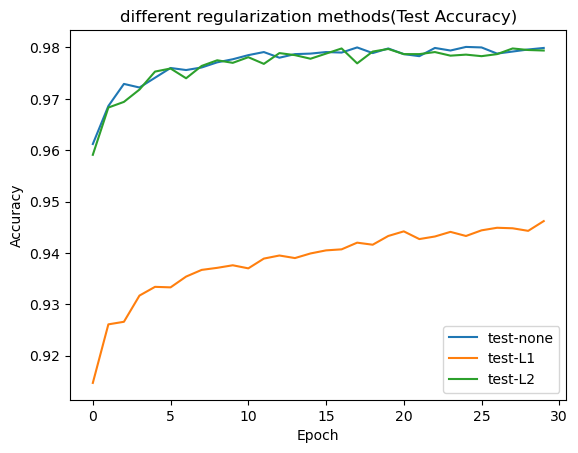

In [4]:
# plt.plot(train_acc_history0, label='train-none')
plt.plot(test_acc_history0, label='test-none')
# plt.plot(train_acc_history, label='train-L1')
plt.plot(test_acc_history, label='test-L1')
# plt.plot(train_acc_history1, label='train-L2')
plt.plot(test_acc_history1, label='test-L2')

plt.title('different regularization methods(Test Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('different regularization methods(Test Accuracy).png')
plt.show()

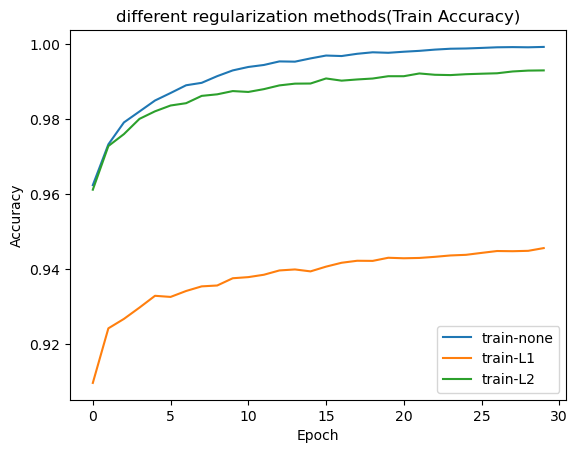

In [5]:
plt.plot(train_acc_history0, label='train-none')
# plt.plot(test_acc_history0, label='test-none')
plt.plot(train_acc_history, label='train-L1')
# plt.plot(test_acc_history, label='test-L1')
plt.plot(train_acc_history1, label='train-L2')
# plt.plot(test_acc_history1, label='test-L2')

plt.title('different regularization methods(Train Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('different regularization methods(Train Accuracy).png')
plt.show()